- Looking for churn which means has not taken a ride in the last 30 days. 

- convert date col. to a date format and they style we want.
- get last trip.max() assign to obj.
- from this data calculate if they did not take a ride within the last 30 days or more timedelta64()


In [25]:
import xgboost as xgb


import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

## Import the Data

In [2]:
web_df = pd.read_csv('churn.csv')
web_df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0


## Review the data and columns

In [3]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
web_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


## Clean the data 
- create indicator variables for categorical data
- Remove and replace null values
    - method used is to create a new indicator column that will be a 1 if column with nulls had a row that was null
    - take the mean of the column (when continuous data)
    - replace nulls with the mean value. 
    - Now the column has all missing values filled in and a new indicator column
    - #### We do similar with categorical data like phone. 
        - Create a new indicator column for rows of column that are null 1 it was null, 0 had a value
        - create indicator columns for the data. in this case android and iphone. 
        - between the 3 columns we know whether it was iphone, android, or other. 

In [5]:
# Convert the data type in the panda dataframe to datetime. 
# this could be done at import when I know what columns to apply datetime to

web_df.last_trip_date = web_df.last_trip_date.astype('datetime64[ns]')
web_df.signup_date = web_df.signup_date.astype('datetime64[ns]')

In [6]:
# get the most recent date and use that to calculate if everyone else has used the service in 30 days or less. 
last_date_service_used = web_df.last_trip_date.max()

print(last_date_service_used)
print(last_date_service_used - web_df.last_trip_date.iloc[0])

web_df['churn'] = (last_date_service_used - web_df.last_trip_date).dt.days > 30
web_df.churn = web_df.churn.astype('int')

2014-07-01 00:00:00
14 days 00:00:00


In [7]:
# viewing changes to the dataframe as I make them below. Keep running this cell to watch the progress, 
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
churn                     50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [8]:
# clean up phone category
web_df['phone_was_null'] = web_df.phone.isnull()
web_df = pd.concat([web_df, pd.get_dummies(web_df.phone)], axis=1)


In [9]:
web_df = pd.concat([web_df, pd.get_dummies(web_df.city, prefix='city_')], axis=1)


In [10]:
# web_df = web_df.drop(["Android", "iPhone"], axis = 1)

In [11]:
#Add days since sign up
web_df['days_since_signup_date'] = (last_date_service_used - web_df.signup_date).dt.days

In [12]:
# there are null values in the avg_rating_by_driver column, so we will perform 2 steps to clean up the data.
# 1. we will create a new category column called rate_by_driver_was_null. For every null we find we put a 1, else 0
# next we will take the mean of the column avg_rating_by_driver and replace the null values with this mean

web_df['rate_by_driver_was_null'] = web_df.avg_rating_by_driver.isnull()
# when checking for Null's I found the following did not work, # web_df.avg_rating_by_driver == np.nan
# so I use the column_name.isnull() method to check the column of the dataframe. print(web_df.avg_rating_by_driver.isnull())

rating_mean = web_df.avg_rating_by_driver.mean()
print(rating_mean)
web_df.avg_rating_by_driver[web_df['rate_by_driver_was_null']== True] = rating_mean


4.778158195947439


/Users/michaelwoline/anaconda2/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# using the above process, we will clean up the remaining data.
web_df['rating_of_driver_was_null'] = web_df.avg_rating_of_driver.isnull()
rating_of_driver_mean = web_df.avg_rating_of_driver.mean()
web_df.avg_rating_of_driver[web_df['rating_of_driver_was_null']== True] = rating_of_driver_mean

/Users/michaelwoline/anaconda2/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [14]:
#Add days since last trip to dataframe
web_df['days_since_last_trip'] = (last_date_service_used - web_df.last_trip_date).dt.days

In [15]:
# checking that assignment through reference succeeded. 
web_df.avg_rating_by_driver[web_df['rate_by_driver_was_null']== True]

90       4.778158
274      4.778158
277      4.778158
536      4.778158
857      4.778158
1021     4.778158
1073     4.778158
1164     4.778158
1181     4.778158
1205     4.778158
1364     4.778158
1420     4.778158
1679     4.778158
1726     4.778158
2112     4.778158
2479     4.778158
2673     4.778158
3071     4.778158
3126     4.778158
3299     4.778158
3818     4.778158
3866     4.778158
3958     4.778158
4481     4.778158
4803     4.778158
5058     4.778158
5151     4.778158
5611     4.778158
5641     4.778158
5820     4.778158
5952     4.778158
6105     4.778158
6547     4.778158
7129     4.778158
7636     4.778158
8606     4.778158
8761     4.778158
8832     4.778158
8862     4.778158
9235     4.778158
9973     4.778158
10372    4.778158
10538    4.778158
10987    4.778158
11100    4.778158
11319    4.778158
11874    4.778158
12709    4.778158
13167    4.778158
13391    4.778158
14042    4.778158
14058    4.778158
14316    4.778158
14359    4.778158
14572    4.778158
14693    4

In [16]:
# create intercept column
web_df['intercept'] = 1

## Subselect the features we want to fit to the model. 
- create a list of features for use with working with the numpy matrixes
- create a clean copy data frame with the desired features for working with later such as the correlation graph

In [17]:
# assign data to feature numpy and outcome numpy array's

# this dataset is going to be used for logistic regression, so I will remove the 
feature_list = ['intercept', 'avg_dist', 'avg_rating_by_driver', 'rate_by_driver_was_null', 'avg_rating_of_driver', \
                'rating_of_driver_was_null', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', \
                'luxury_car_user', 'weekday_pct', 'phone_was_null', 'Android', 'iPhone', 'city__Astapor', \
                "city__King's Landing", "city__Winterfell"]

cleaned_web_df = web_df[feature_list + ['churn']].copy()

## Remove referent column from each indicator value groups. 
feature_list_LR_ready = ['intercept', 'avg_dist', 'avg_rating_by_driver', 'rate_by_driver_was_null', 'avg_rating_of_driver', \
                'rating_of_driver_was_null', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', \
                'luxury_car_user', 'weekday_pct', 'phone_was_null', 'Android', 'city__Astapor', \
                "city__Winterfell"]


# when features were scaled inside the kfold process for statsmodel, the fit blew up with "singular matrix" error.
# my guess was the values became too small or the indicator variables caused problems. After further research,
# it looks like the indicator variables are the issue, so these will be split out from continuous data.
# the data will be scaled, and indicator variables added in. 
feature_list_LR_ready_indicator = ['intercept', 'rate_by_driver_was_null', 'rating_of_driver_was_null', \
                'luxury_car_user', 'phone_was_null', 'Android', 'city__Astapor', "city__Winterfell"]

feature_list_LR_ready_continuous = ['avg_dist', 'avg_rating_of_driver', 'avg_rating_by_driver', \
                                    'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

##         Not used     
# city
# last_trip_date               
# phone                        
# signup_date                  
# days_since_signup_date       
# days_since_last_trip         

X = cleaned_web_df[feature_list_LR_ready_continuous + feature_list_LR_ready_indicator].as_matrix().astype(float)
y = cleaned_web_df.churn.as_matrix().astype(float)

## Look at cleaned dataset for correlation and other confounders before building model.

In [18]:

# np.linalg.det(X_train.T.dot(X_train))
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIFs = [0] * len(feature_list_LR_ready)

for c, val in enumerate(feature_list_LR_ready):
#     print(val)
    VIFs[c] = variance_inflation_factor(X_train,c)
    print(c, VIFs[c], feature_list_LR_ready[c])


NameError: name 'X_train' is not defined

In [19]:
cleaned_web_df.corr()

,intercept,avg_dist,avg_rating_by_driver,rate_by_driver_was_null,avg_rating_of_driver,rating_of_driver_was_null,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,phone_was_null,Android,iPhone,city__Astapor,city__King's Landing,city__Winterfell,churn
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_dist,NaN,1.000000,7.979292e-02,4.122445e-03,2.850771e-02,1.319052e-01,-0.081491,-0.104414,-0.136329,0.032310,0.101652,0.022372,0.020888,-0.025030,-0.045431,0.015877,0.030050,0.092780
avg_rating_by_driver,NaN,0.079793,1.000000e+00,-3.846635e-14,1.016603e-01,7.667827e-03,0.010498,0.019964,-0.039097,0.009328,0.020366,0.007433,0.008765,-0.010127,0.032518,0.084480,-0.098727,0.026748
rate_by_driver_was_null,NaN,0.004122,-3.846635e-14,1.000000e+00,-5.655505e-03,2.943462e-02,0.026019,0.021980,-0.028912,-0.027256,-0.013179,0.005021,0.001111,-0.002067,-0.005688,-0.000568,0.005822,0.025834
avg_rating_of_driver,NaN,0.028508,1.016603e-01,-5.655505e-03,1.000000e+00,-1.207339e-13,-0.021653,-0.003290,-0.011060,-0.001916,0.012587,0.001530,0.024206,-0.024323,0.029814,0.082156,-0.094304,0.010829
rating_of_driver_was_null,NaN,0.131905,7.667827e-03,2.943462e-02,-1.207339e-13,1.000000e+00,0.006826,-0.006652,-0.195643,-0.036656,-0.022270,0.019375,0.052966,-0.056298,0.023191,-0.048904,0.017531,0.159232
avg_surge,NaN,-0.081491,1.049772e-02,2.601933e-02,-2.165276e-02,6.825719e-03,1.000000,0.793582,-0.001841,-0.078791,-0.110071,-0.011423,-0.008977,0.011104,0.037172,-0.009198,-0.027643,0.003333
surge_pct,NaN,-0.104414,1.996390e-02,2.198027e-02,-3.290168e-03,-6.651979e-03,0.793582,1.000000,0.005720,-0.106861,-0.144918,-0.014456,-0.010150,0.012851,0.045457,0.028221,-0.065603,-0.011797
trips_in_first_30_days,NaN,-0.136329,-3.909724e-02,-2.891189e-02,-1.105974e-02,-1.956426e-01,-0.001841,0.005720,1.000000,0.112210,0.050388,0.002786,-0.059309,0.058342,-0.061075,0.024650,0.037735,-0.210463
luxury_car_user,NaN,0.032310,9.328399e-03,-2.725606e-02,-1.916192e-03,-3.665596e-02,-0.078791,-0.106861,0.112210,1.000000,0.035998,0.043145,-0.075836,0.067002,0.021259,0.039649,-0.051990,-0.205002


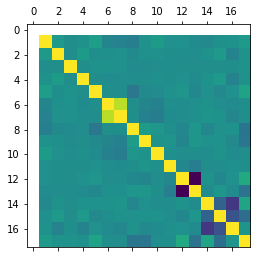

In [20]:
plt.matshow(cleaned_web_df.corr())

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import statsmodels.discrete.discrete_model as sm
from statsmodels.api import Logit

In [22]:
def my_classification_metrics(confusion_matrix):
    ''' 
    Scoring metrics for model fit comparisons.
    
    
    Accuracy calc:
        (TP + TN)/(TP + TN + FP + FN) 
        we want high tp and tn
    
    my_sensitivity_calc():
        TP/(TP + FN) we called this power and = 1 - β and β = FN/(FN + TP) 
        we want higher power aka optimistic view
    
    my_specificity_calc():
        is 1−α = TN/(FP + TN) 
        fraction of truth over negative truth plus truth. 
        we want this small so a pessimistic view.
    
    Precision Calc:
        positive predictive value: - 
        TP /(TP + FP)
    '''
    TN = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TP = confusion_matrix[1][1]

    accuracy =  (TP + TN)/(TP + TN + FP + FN) 
    sensitivity = TP/(TP + FN)
    specificity = TN/(FP + TN)
    precision = TP /(TP + FP)
    
    return(accuracy, sensitivity, specificity, precision)

## Data Pipeline and additional processing note for next cell:
- Data prep would normally be done differently, but because I had all of the data up front, I could preprocess all up front. 
- Usually, we would pipeline the data as follows:
    - Run the data through the initial cleanse process that will add the indicator columns and transform indicator variables, etc. 
    - We would add missing values inside the k-folds loop where X is split into train and test data. 
        - we can add values by using the mean of the column. 
        - Another option is to try to predict those missing values from the other features. 
        - We might try to see if the values were missing on purpose. 
    - Once values are added, we would apply the same process to the test data.
        - We will want to fill in values based on current k-fold train, and use that on the test data as well. 
        - This is why when we don't have all of the data up front as in continuous data collection we perform the the missing value calculations when X is split. or a new Test set is about to be predicted.

In [41]:


# switch between models: statsmodel or sckit-learn
which_model = "xgboost" #"statsmodel" #"scikit-learn" # 

n_splits = 3
kf = KFold(n_splits, random_state=0, shuffle=True)

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ## Data processing pipeline would continue here. See above for note. 
    
    
    # Feature Scaling
    sc = StandardScaler()
    # scale on continuous features only to avoid issues with statsmodels giving "singular matrix" error
    
    X_train_temp = sc.fit_transform(X_train[:, 0: len(feature_list_LR_ready_continuous)])
    temp_indicator_data = X_train[:, len(feature_list_LR_ready_continuous) :]
    X_train = np.concatenate((X_train_temp, temp_indicator_data), axis=1)

    X_test = np.concatenate((sc.transform(X_test[:, 0: len(feature_list_LR_ready_continuous)]), \
                             X_test[:, len(feature_list_LR_ready_continuous) :]), axis=1)

    
    if which_model=="scikit-learn":
        ####   Using scikit-learn for fit and predict

        # Fitting Logistic Regression to the Training set
        classifier = LogisticRegression(random_state = 0)
        classifier.fit(X_train, y_train)

        # Predicting the Test set results
        y_pred = classifier.predict(X_test)

    elif which_model == "statsmodel":
        ##### .  Using Statsmodels

        model = Logit(y_train, X_train)
        result = model.fit()

        y_pred_probability = result.predict(X_test)

        #convert statsmodel outcomes from their native probability to a classification of (1,0) 
        # then the rest of the code will flow as expected. 
        # statsmodel outcome gives me an opportunity to threshold and change outcomes 
        y_pred = (y_pred_probability >= .5).astype(int)  
        
        # side note, until regularization is added into the statsmodel, the outcomes from scikit and statsmodel 
        # will differ slightly. I found it was between 1 and 5 for the approximately 16,000 predictions.
        # used the following to validate the outcomes.
#             print(y_pred_scikit)
#             print(np.sum(y_pred_scikit))
#             print(len(y_pred_scikit))
#             print(y_pred)
#             print(np.sum(y_pred >= .5))
    
    elif which_model == "xgboost":
        xg_train = xgb.DMatrix(X_train, label = y_train)
        xg_test = xgb.DMatrix(X_test, label = y_test)
        param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
        num_round = 10
        bst = xgb.train(param, xg_train, num_round) #, evallist)
        
        # prediction
        y_pred_probability = bst.predict(xg_test)
        print(y_pred_probability.shape)
        y_pred = (y_pred_probability >= .5).astype(int)
        print(y_pred.shape, y_test.shape)

    # Making the Confusion Matrix
    cm_out_of_sample = confusion_matrix(y_test, y_pred)
   
    # score the model. 
    print("My precision Score  out of sample", my_classification_metrics(cm_out_of_sample)[0])
    print()
    print(metrics.classification_report(y_test, y_pred))

(16667,)
(16667,) (16667,)
My precision Score  out of sample 0.779624407512

             precision    recall  f1-score   support

        0.0       0.73      0.65      0.69      6236
        1.0       0.80      0.86      0.83     10431

avg / total       0.78      0.78      0.78     16667

(16667,)
(16667,) (16667,)
My precision Score  out of sample 0.772304553909

             precision    recall  f1-score   support

        0.0       0.73      0.63      0.68      6295
        1.0       0.79      0.86      0.82     10372

avg / total       0.77      0.77      0.77     16667

(16666,)
(16666,) (16666,)
My precision Score  out of sample 0.784351374055

             precision    recall  f1-score   support

        0.0       0.75      0.64      0.69      6273
        1.0       0.80      0.87      0.83     10393

avg / total       0.78      0.78      0.78     16666



In [38]:
print(y_test.shape)
print(X_test.shape)
print(X_train.shape)
print(y_pred.shape)


(16667,)
(16667, 15)
(33333, 15)
(16666,)


## Improve Model Prediction Rate Out of Sample Scores - Add higher order terms:
- By adding higher order terms, the model will begin to overfit the data, and the insample prediction scores will rise. Too much of a rise, and the out of sample scores will decrease. 
- When this happens, we can run the result.summary() table below to see what terms to throw out. 
    - if we find some terms with a high p value > .05, then we fail to reject the null hypothesis. 
    - The null hypothesis says this term has no effect. so for P values < .05 we reject the null hypothesis and keep those terms. ;
    - This is called backward selection. 
    
    
### I'll return to backward selection and higher order terms later. 

In [287]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                33334
Model:                          Logit   Df Residuals:                    33319
Method:                           MLE   Df Model:                           14
Date:                Thu, 08 Feb 2018   Pseudo R-squ.:                  0.1627
Time:                        14:14:16   Log-Likelihood:                -18478.
converged:                       True   LL-Null:                       -22068.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1727      0.015     11.799      0.000       0.144       0.201
x2             0.0282      0.012      2.270      0.023       0.004       0.052
x3             0.0845      0.013      6.696      0.000       0.060       0.109
x4             0.0443      0.022      2.017      0.044       0.001       0.087
x5            -0.0889      0.022     -4.132      0.000      -0.131      -0.047
x6            -0.3995      0.016    -25.105      0.000      -0.431      -0.368
x7             0.0166      0.013      1.263      0.207      -0.009       0.042
const         -0.6102      0.030    -20.091      0.000      -0.670      -0.551
x8             0.5370      0.221      2.428      0.015       0.103       0.971
x9             0.6951      0.039     17.604      0.000       0.618       0.773
x10           -0.8613      0.026    -32.790      0.000      -0.913      -0.810
x11            0.5836      0.145      4.030      0.000       0.300       0.867
x12            1.0183      0.030     34.066      0.000       0.960       1.077
x13            1.6919      0.036     46.718      0.000       1.621       1.763
x14            1.1978      0.033     36.057      0.000       1.133       1.263
==============================================================================
"""

## Create Cost/Benefit Matrices and Plot as ROC curves, etc. 

    - prediction

- t   0    |  1  
- r   TN   |  FP
- u  ----------------
- t   0    |  1
- h   FN   |  TP

#### Cost Benefit Assumptions:
- We'll use the following:
    - Average cost per trip is about $$26. (per early 2015 stats from NY)  $
    - Average number of trips per month is 4
    - In order to keep a rider active, we will offer 25% off the next 2 rides
    - Losses will be calculated for next 2 months. 
    
#### Costs
- TN - not predicted to churn, so no action taken or costs
- FP - spend 25% off next 2 rides = 2* 6.5 = 13.
- FN - Lose 2 months of rides = $$26 * 8 = $208
- TP - lose 2 months of rides = $$26 * 6 = $156 + 13 discount because they stay for 2 more rides. 

#### Benefits matrix
- TN - gain the next 2 months in rides = 208
- FP - gain the next 2 months in rides = 208
- FN - 
- TP - 0 no benefit from predicting they will churn and they do churn